# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Online Payments Fraud Exploration Notebook And Cleaning</div></center></span>

## Bussiness Understanding

## Data Understanding

- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Import Necessary Libraries</div></center></span>

In [72]:
# Exploration purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Model related
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import GridSearchCV
from joblib import dump
from joblib import load

# Data balancing
from collections import Counter
from imblearn.over_sampling import SMOTE

# Other
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Load Dataset</div></center></span>

In [73]:
dataset_dir = '../dataset/fraud-payments.csv.csv'
payment_fraud_df = pd.read_csv(dataset_dir)

In [74]:
# Check dataset preview
payment_fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Exploratory Data Analysis</div></center></span>

## Check Basic Data Info

In [75]:
# See basic info
payment_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Seems like our dataset consists of 6362620 rows and 11 columns.  With 1 containing column labels, 3 column have object dtypes and the rest is numeric dtypes.

In [76]:
# Check if there's null value
payment_fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [77]:
# Check duplicated data, because there is no distinct id column we can check duplicated records with multiple column
duplicates = payment_fraud_df[payment_fraud_df.duplicated(['nameOrig', 'nameDest', 'step'])]

In [78]:
if duplicates.empty:
    print("There's no duplicate record.")
else:
    print(f'Duplicates record found: {duplicates}')


There's no duplicate record.


In [114]:
# See label distribution
payment_fraud_df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [80]:
fraud_percentage = (8213/6362620)*100
nonfraud_percentage = (6354407/6362620)*100

print(f"""We can see that this dataset is very imbalanced with fraud transaction only {fraud_percentage:.1f}% and 
    non-fraud transaction {nonfraud_percentage:.1f}%, This is expected of this kind of dataset because there is 
    no way majority of our transaction are gonna be fraud else there is something wrong with the system.""")

We can see that this dataset is very imbalanced with fraud transaction only 0.1% and 
    non-fraud transaction 99.9%, This is expected of this kind of dataset because there is 
    no way majority of our transaction are gonna be fraud else there is something wrong with the system.


## Object Data Exploratory

In [81]:
object_features = payment_fraud_df.select_dtypes(include=object).columns.tolist()
object_features

['type', 'nameOrig', 'nameDest']

From the early preview, we can see that type "column" is categorical, but "nameOrig" and "nameDest" is just a string name like some sort of sender and receiver id.

### Online Transaction Type

In [82]:
type = payment_fraud_df[object_features[0]]
type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

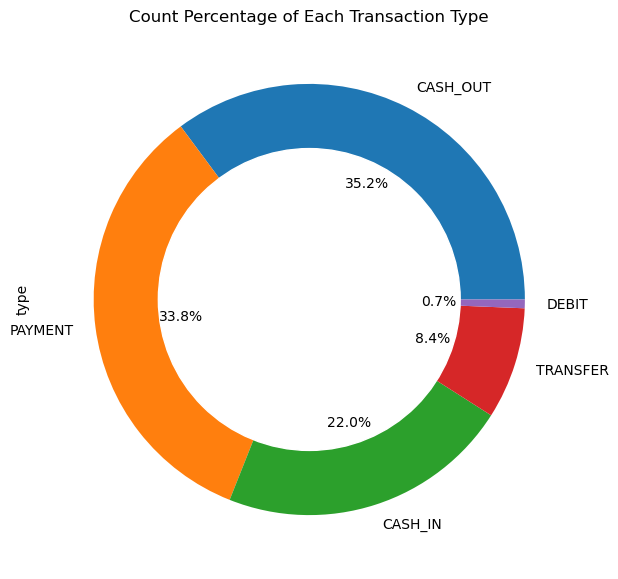

In [83]:
type.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,7))
circle = plt.Circle((0, 0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.title('Count Percentage of Each Transaction Type')

plt.show()

From the donut plot above, we can see that the most used type from these online transaction is 'Cash Out'.  'Cash out' is a financial term that refers to the process of converting an asset into cash, typically by selling the asset. The term is often used in the context of real estate or business transactions where one party "cashes out" by selling their share of the property or business to another party for a profit.

In some contexts, "cash out" may also refer to withdrawing cash from an account, such as a bank account or a digital wallet, or to using a credit card to obtain cash.

Now, let's see how much from those online transaction type that actually is fraud

In [116]:
# Number of total fraud
total_fraud = payment_fraud_df['isFraud'].value_counts()[1]
total_fraud

8213

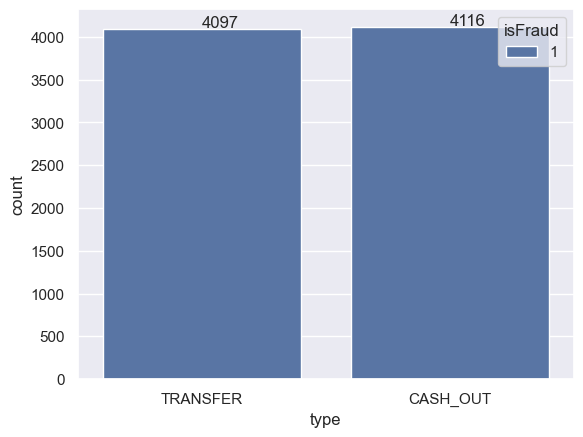

In [118]:
sns.set(style="darkgrid")
sns.countplot(x='type', hue='isFraud', data=payment_fraud_df[payment_fraud_df['isFraud'] == 1])
ax = plt.gca()

# Add count values to each bar
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+20))

plt.show()


Out of 5 transaction type, seems like there are 2 out of 5 type that contains fraud.  Which is 4097 cases on transfer and 4116 cases on cash out with all of the total fraud cases is 8213.

### Name Origin and Destination

In [97]:
# Let's see unique value of this column
name_origin = payment_fraud_df[object_features[1]]
unique_origin = name_origin.nunique()
unique_origin

6353307

Seems like the unique value is a bit different from the total number of records, lets check:

In [90]:
diff = name_origin.count() - name_origin.nunique()
diff

9313

It's true that there are difference in value, this means that there are IDs who did multiple transaction.  Let's check:

In [94]:
name_origin.value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

Now let's see the name destination:

In [98]:
name_destination = payment_fraud_df[object_features[2]]
unique_dest = name_destination.nunique()
unique_dest

2722362

In [96]:
diff2 = name_destination.count() - name_destination.nunique()
diff2

3640258

In [100]:
# Count diff percentage between dest and origin
diff_percentage = (unique_dest/unique_origin)*100
diff_percentage

42.84952702584654

Seems like there are even more difference on the destination, more than half even.  This means that some origin user did an online transaction with the same destination user, perhaps could be an online seller account or something.  Because the value of destination is only 42,8 % of the origin user. 

That's all we can get from the object-type columns, in the context of machine learning the 'nameOrig' and 'nameDest' column won't be used to feed the train data because most of it are unique and does not provide meaningful information to serve as pattern/relationship for the algorithm to learn from, that's why we are gonna drop these column later.  But we do explore it as well, just for the insight gain.

## Numerical Features Exploratory

In [ ]:
test